In [38]:
import pandas as pd
import matplotlib.pyplot as plt  # Add this import
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.utils.statistics import (
    stationarity_tests,
    plot_acf,
    plot_hist
)
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


In [39]:
# 1. Data load
cons_3U = pd.read_csv(r"C:\Users\dmarc\Desktop\EWELD_Energy_project\data\processed\Energy_C_cons_3U.csv")

Use separate TimeSeries objects (one per user) for independent analysis/classification to:

1. **Stationarity tests** - ADF & KPSS.
2. **Decomposition of the series** – to identify trend, seasonality and residuals
3. **Classification of users** – based on variability and temporal patterns.

In [52]:
# Step 1: Imports
import pandas as pd
import matplotlib.pyplot as plt
from darts import TimeSeries
from darts.utils.statistics import stationarity_tests, stationarity_test_adf, stationarity_test_kpss, plot_acf, plot_hist
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np


In [68]:
# Step 2: Load and verify data
cons_3U = pd.read_csv(r"C:\Users\dmarc\Desktop\EWELD_Energy_project\data\processed\Energy_C_cons_3U.csv")
cons_3U['Time'] = pd.to_datetime(cons_3U['Time'])
print("Data loaded successfully")
print("Missing values check:")
print(cons_3U.isna().sum())
print(f"\nDate range: {cons_3U['Time'].min()} to {cons_3U['Time'].max()}")
print(f"15-minute interval confirmed: {(cons_3U['Time'].diff().dropna().value_counts().index[0] == pd.Timedelta(minutes=15))}")
print(f"\nColumns:{cons_3U.columns}")
print(' ====================')
print(cons_3U['User'].unique())



Data loaded successfully
Missing values check:
Time                       0
Energy_int_linear [kWh]    0
User                       0
dtype: int64

Date range: 2016-06-02 00:15:00 to 2021-10-25 15:30:00
15-minute interval confirmed: True

Columns:Index(['Time', 'Energy_int_linear [kWh]', 'User'], dtype='object')
['U117' 'U151' 'U196']


In [69]:
# Step 3: Create TimeSeries objects
user_series = {}
for user in cons_3U['User'].unique():
    user_df = cons_3U[cons_3U['User'] == user].sort_values('Time')
    ts = TimeSeries.from_dataframe(
        user_df,
        time_col='Time',
        value_cols='Energy_int_linear [kWh]',
        freq='15min'  # Explicit 15-minute frequency
    )
    user_series[user] = ts
print(f"\nCreated TimeSeries for {len(user_series)} users")



Created TimeSeries for 3 users



─── User: U117 ───
Duration: 1547 days 09:45:00


c:\Users\dmarc\Desktop\EWELD_Energy_project\.venv_e310\lib\site-packages\darts\utils\statistics.py:479: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  return kpss(ts.values(copy=False), regression, nlags)


ADF Stationary: (np.float64(-5.443966147640618), np.float64(2.7366798223446876e-06), 75, 148476, {'1%': np.float64(-3.4303940435697275), '5%': np.float64(-2.8615594666378286), '10%': np.float64(-2.566780361397929)}, np.float64(802118.5461981496)), KPSS Stationary: (np.float64(17.149884644463675), np.float64(0.01), 224, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})


<Figure size 1000x400 with 0 Axes>

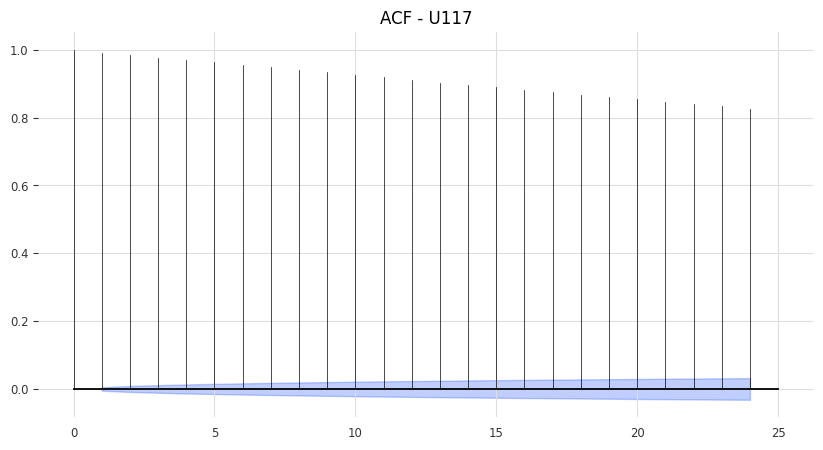

<Figure size 1000x400 with 0 Axes>

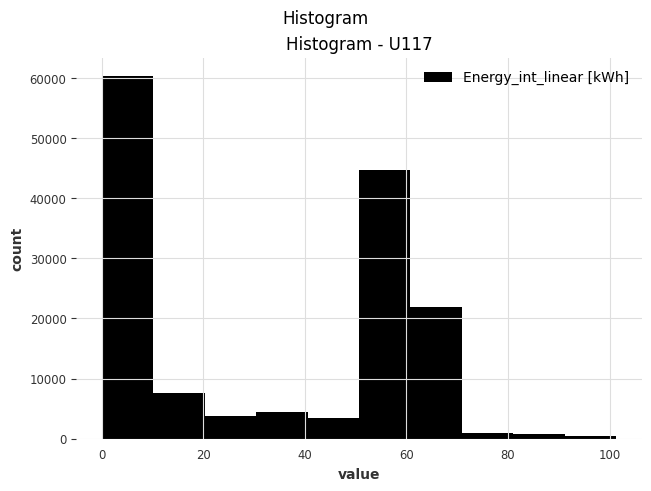


─── User: U151 ───
Duration: 1544 days 23:30:00


c:\Users\dmarc\Desktop\EWELD_Energy_project\.venv_e310\lib\site-packages\darts\utils\statistics.py:479: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  return kpss(ts.values(copy=False), regression, nlags)


ADF Stationary: (np.float64(-17.552828580717197), np.float64(4.134053002970711e-30), 75, 148243, {'1%': np.float64(-3.430394112796129), '5%': np.float64(-2.8615594972346963), '10%': np.float64(-2.566780377683591)}, np.float64(1740070.1369551183)), KPSS Stationary: (np.float64(10.92573108189496), np.float64(0.01), 212, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})


<Figure size 1000x400 with 0 Axes>

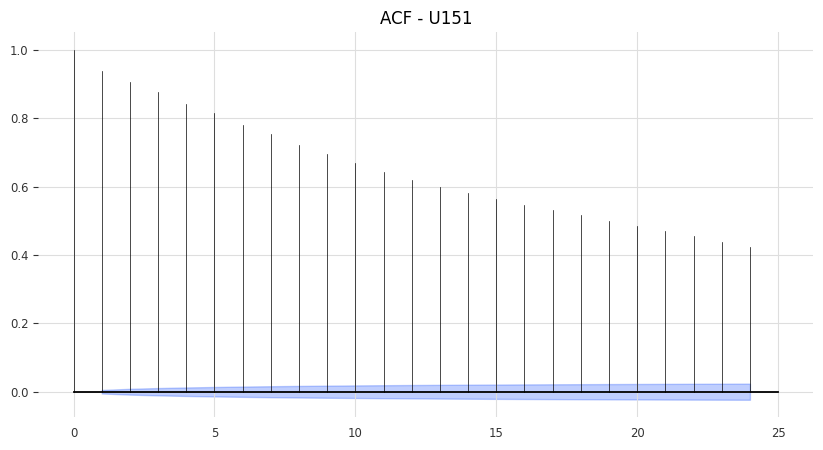

<Figure size 1000x400 with 0 Axes>

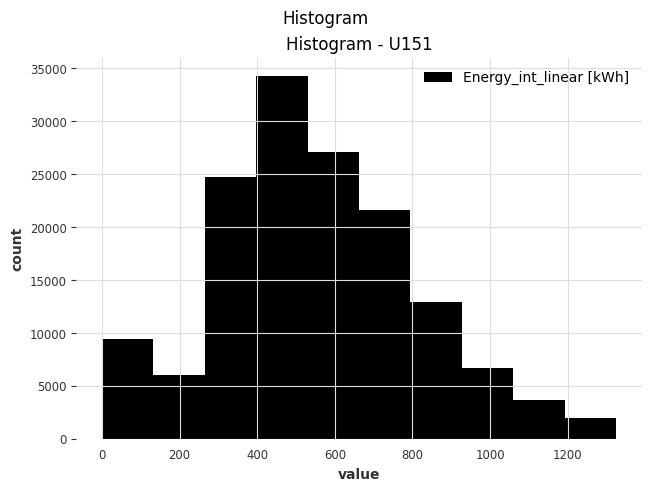


─── User: U196 ───
Duration: 1532 days 23:45:00


c:\Users\dmarc\Desktop\EWELD_Energy_project\.venv_e310\lib\site-packages\darts\utils\statistics.py:479: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  return kpss(ts.values(copy=False), regression, nlags)


ADF Stationary: (np.float64(-22.68789580057065), 0.0, 75, 147092, {'1%': np.float64(-3.4303944579863126), '5%': np.float64(-2.861559649802753), '10%': np.float64(-2.5667804588903333)}, np.float64(749764.547058895)), KPSS Stationary: (np.float64(0.976040354251458), np.float64(0.01), 204, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})


<Figure size 1000x400 with 0 Axes>

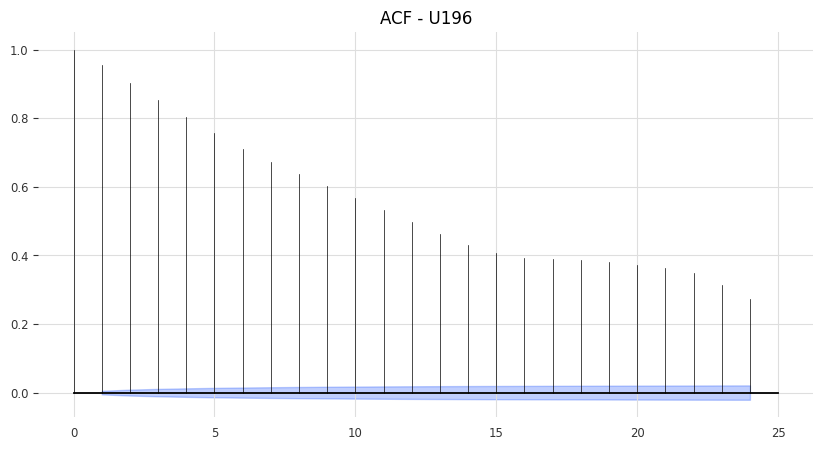

<Figure size 1000x400 with 0 Axes>

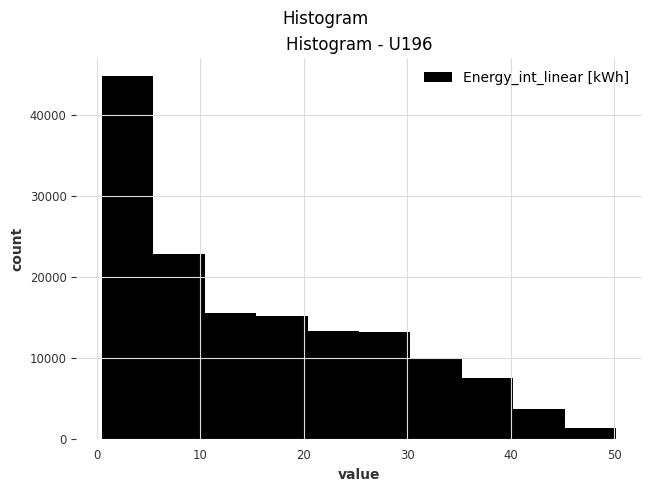

In [70]:
# Step 4: Stationarity analysis
for user, ts in user_series.items():
    print(f"\n─── User: {user} ───")
    print(f"Duration: {ts.duration}")
    
    # Stationarity tests
    adf_result = stationarity_test_adf(ts)
    kpss_result = stationarity_test_kpss(ts)
    print(f"ADF Stationary: {adf_result}, KPSS Stationary: {kpss_result}")
    
    # ACF plot
    plt.figure(figsize=(10, 4))
    plot_acf(ts)
    plt.title(f"ACF - {user}")
    plt.show()
    
    # Histogram
    plt.figure(figsize=(10, 4))
    plot_hist(ts)
    plt.title(f"Histogram - {user}")
    plt.show()



─── Decomposition: U117 ───
Start: 2017-07-15 00:15:00, End: 2021-10-09 10:00:00
Length: 148552, Frequency: <15 * Minutes>
Missing values: 0


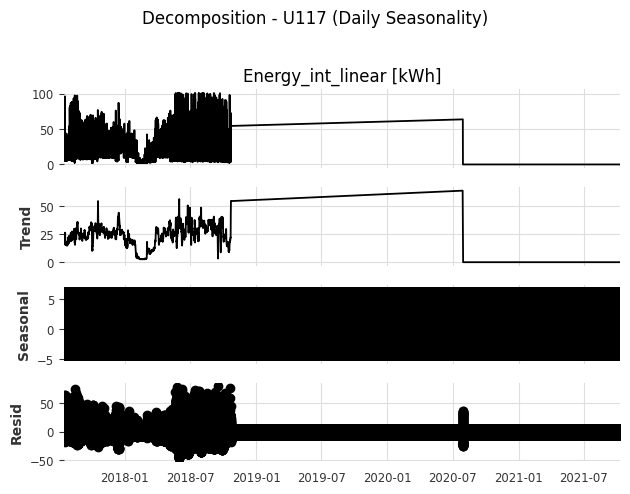


─── Decomposition: U151 ───
Start: 2017-08-02 16:00:00, End: 2021-10-25 15:30:00
Length: 148319, Frequency: <15 * Minutes>
Missing values: 0


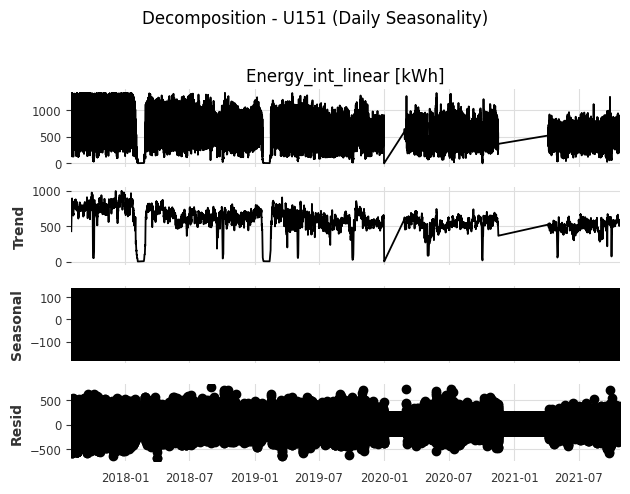


─── Decomposition: U196 ───
Start: 2016-06-02 00:15:00, End: 2020-08-13 00:00:00
Length: 147168, Frequency: <15 * Minutes>
Missing values: 0


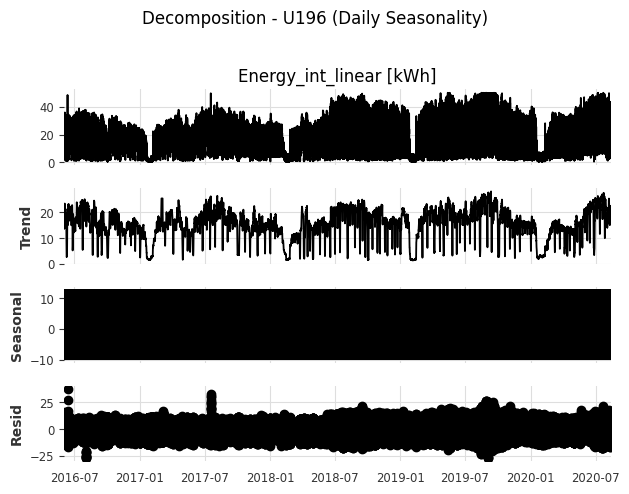

In [71]:
# Step 5: Time series decomposition (daily seasonality)
for user, ts in user_series.items():
    print(f"\n─── Decomposition: {user} ───")
    
    # SIMPLE CONVERSION METHOD (works with all Darts versions)
    # Extract values and time index
    values = ts.values().flatten()  # Get values as 1D array
    time_index = ts.time_index  # Get datetime index
    
    # Create pandas Series
    ts_series = pd.Series(values, index=time_index, name='Energy_int_linear [kWh]')
    
    # Ensure frequency is set (critical for decomposition)
    ts_series = ts_series.asfreq('15min')
    
    # Handle any new missing values
    if ts_series.isna().sum() > 0:
        print(f"Filling {ts_series.isna().sum()} missing values with 0")
        ts_series = ts_series.fillna(0)
    
    # Diagnostic info
    print(f"Start: {ts_series.index[0]}, End: {ts_series.index[-1]}")
    print(f"Length: {len(ts_series)}, Frequency: {ts_series.index.freq}")
    print(f"Missing values: {ts_series.isna().sum()}")
    
    # Skip if too short for daily seasonality
    if len(ts_series) < 192:  # 2 full days (96*2)
        print(f"Series too short for decomposition ({len(ts_series)} < 192)")
        continue
    
    try:
        # Daily seasonality: 24 hours * 4 intervals/hour = 96
        result = seasonal_decompose(ts_series, 
                                    model='additive', 
                                    period=96,
                                    extrapolate_trend='freq')
        
        # Plot decomposition
        result.plot()
        plt.suptitle(f"Decomposition - {user} (Daily Seasonality)", y=1.02)
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Decomposition failed: {str(e)}")


Classification Report:
              precision    recall  f1-score   support

        U117       0.00      0.00      0.00       1.0
        U196       0.00      0.00      0.00       0.0

    accuracy                           0.00       1.0
   macro avg       0.00      0.00      0.00       1.0
weighted avg       0.00      0.00      0.00       1.0



c:\Users\dmarc\Desktop\EWELD_Energy_project\.venv_e310\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\dmarc\Desktop\EWELD_Energy_project\.venv_e310\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\dmarc\Desktop\EWELD_Energy_project\.venv_e310\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

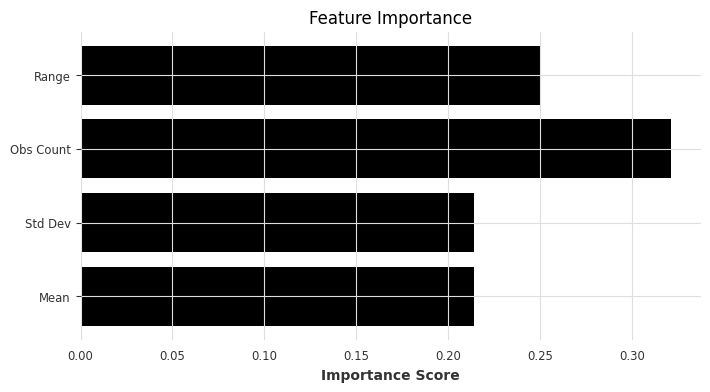

In [65]:
# Step 6: User classification
features = []
labels = []

for user, ts in user_series.items():
    vals = ts.values().flatten()
    features.append([
        vals.mean(),    # Mean consumption
        vals.std(),     # Consumption variability
        len(vals),     # Number of observations
        vals.max() - vals.min()  # Consumption range
    ])
    labels.append(user)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    features, 
    labels, 
    test_size=0.33, 
    random_state=42
)

# Train classifier
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)

# Evaluate
y_pred = clf.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Feature importance
feature_names = ['Mean', 'Std Dev', 'Obs Count', 'Range']
importances = clf.feature_importances_

plt.figure(figsize=(8, 4))
plt.barh(feature_names, importances)
plt.title("Feature Importance")
plt.xlabel("Importance Score")
plt.show()